Team members:

  * Omnia Karem Mahmoud Mahfouz..............21010299
  * Nouran Ashraf Yusef....................................21011492
  * Rana Mohamed Ali Attia..............................21010528

# Imports

In [205]:
import numpy as np
import torch
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import time
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import mnist
import torch.nn as nn
import torch.optim as optim

# Utility Functions

In [206]:
def acc_loss_plots(history):
    # Plot the loss curves
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

    # Plot the accuracy curves
    plt.plot(history['accuracy'], label='train acc')
    plt.plot(history['val_accuracy'], label='val acc')
    plt.legend()
    plt.show()

In [207]:
def visualize_predictions(predictions, x_test, y_test, class_names, num_images=10, rows=4, cols=5):
    sample_indices = np.random.choice(x_test.shape[0], num_images, replace=False)
    plt.figure(figsize=(15, 15))

    for i, idx in enumerate(sample_indices):
        plt.subplot(rows, cols, i + 1)
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)
        plt.imshow(x_test[idx].reshape(28, 28), cmap=plt.cm.binary)
        
        if predictions.ndim > 1: 
            predicted_label = np.argmax(predictions[idx])  
        else:
            predicted_label = predictions[idx]  

        true_label = y_test[idx]

        color = 'green' if predicted_label == true_label else 'red'
        plt.xlabel(f"{class_names[predicted_label]} (True: {class_names[true_label]})", color=color)

    plt.tight_layout()
    plt.show()


In [208]:
def plot_confusion_matrix(predictions, y_test, class_names,title, color="Blues"):
    if predictions.ndim == 1:
        pred_classes = predictions
    else:
        # convert predicted probabilities to class indices
        pred_classes = np.argmax(predictions, axis=1)

    # calculate the confusion matrix
    cm = confusion_matrix(y_test, pred_classes)

    # plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=color,
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted', color='purple')
    plt.ylabel('True', color='green')
    plt.title(title, color='blue')
    plt.show()


# Data Preparation
- **Normalization**: Preprocessed the data by normalizing pixel values to the range [0, 1].  
- **Flattening**: Converted 28x28 images into 1D vectors of size 784.  
- **Dataset Split**: Divided the dataset into:
  - **60% Training**  
  - **20% Validation**  
  - **20% Testing**

In [245]:
def data_preperation(batch_size = 64):
    # 1. Load MNIST dataset from keras
    (x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

    # 2. Preprocess data
    x_train_full = x_train_full.astype('float32') / 255.0  # Normalize to [0, 1]
    x_test = x_test.astype('float32') / 255.0

    # Flatten images to 1D vectors
    x_train_full = x_train_full.reshape(-1, 28 * 28)
    x_test = x_test.reshape(-1, 28 * 28)

    # Split the data
    x_train, x_val, y_train, y_val = train_test_split(
        x_train_full, y_train_full, test_size=0.2, random_state=42
    )

    # Convert data to PyTorch tensors
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                                torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32),
                                torch.tensor(y_val, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                                torch.tensor(y_test, dtype=torch.long))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    return train_loader, val_loader, test_loader
train_loader, val_loader, test_loader = data_preperation(batch_size=64)

# Softmax Regression
- Built a Softmax Regression model using PyTorch with the following specifications:  
  - **Input Size**: 784 (flattened image size).  
  - **Output Classes**: 10 (digits 0-9).  

In [247]:
# Define the Softmax Regression Model
class SoftmaxRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) # lr: learning rate

# Training the model
def train_model(optimizer, model, train_loader, val_loader, epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, "
              f"Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, "
              f"Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [248]:
start_time = time.time()
train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer,  model, train_loader, val_loader, epochs=50)
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}

Epoch 1/50, Train Loss: 1.0604, Train Accuracy: 78.79%, Val Loss: 0.6801, Val Accuracy: 85.01%
Epoch 2/50, Train Loss: 0.5940, Train Accuracy: 86.30%, Val Loss: 0.5330, Val Accuracy: 86.83%
Epoch 3/50, Train Loss: 0.5021, Train Accuracy: 87.51%, Val Loss: 0.4734, Val Accuracy: 87.84%
Epoch 4/50, Train Loss: 0.4578, Train Accuracy: 88.22%, Val Loss: 0.4393, Val Accuracy: 88.32%
Epoch 5/50, Train Loss: 0.4303, Train Accuracy: 88.65%, Val Loss: 0.4168, Val Accuracy: 88.84%
Epoch 6/50, Train Loss: 0.4114, Train Accuracy: 89.13%, Val Loss: 0.4002, Val Accuracy: 89.22%
Epoch 7/50, Train Loss: 0.3970, Train Accuracy: 89.34%, Val Loss: 0.3884, Val Accuracy: 89.38%
Epoch 8/50, Train Loss: 0.3858, Train Accuracy: 89.64%, Val Loss: 0.3785, Val Accuracy: 89.66%
Epoch 9/50, Train Loss: 0.3767, Train Accuracy: 89.78%, Val Loss: 0.3697, Val Accuracy: 89.93%
Epoch 10/50, Train Loss: 0.3691, Train Accuracy: 89.96%, Val Loss: 0.3630, Val Accuracy: 90.13%
Epoch 11/50, Train Loss: 0.3626, Train Accuracy: 

# Visualizations

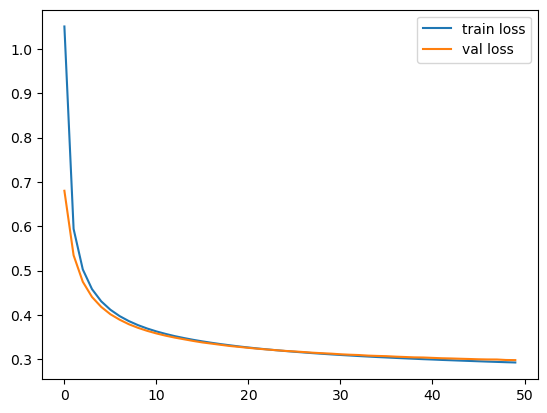

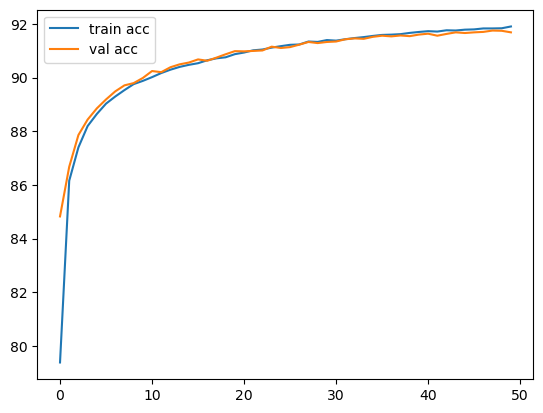

In [212]:
acc_loss_plots(history)

# Analysis

### Evaluation

In [213]:
def evaluate_model():
    test_loss = 0
    correct = 0
    model.eval()

    test_pred = []  # To store predictions
    true_labels = []  # To store true labels
    x_test = []  # To store test images for visualization

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch.float())
            test_loss += criterion(outputs, y_batch).item()

            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()

            # Store batch-wise data for visualization
            test_pred.extend(preds.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())
            x_test.extend(X_batch.cpu().numpy())

    # Compute Test Accuracy
    test_accuracy = correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Convert lists to numpy arrays
    test_pred = np.array(test_pred)
    y_test = np.array(true_labels)
    x_test = np.array(x_test)
    return test_pred, x_test, y_test

Test Loss: 0.2867, Test Accuracy: 0.9187


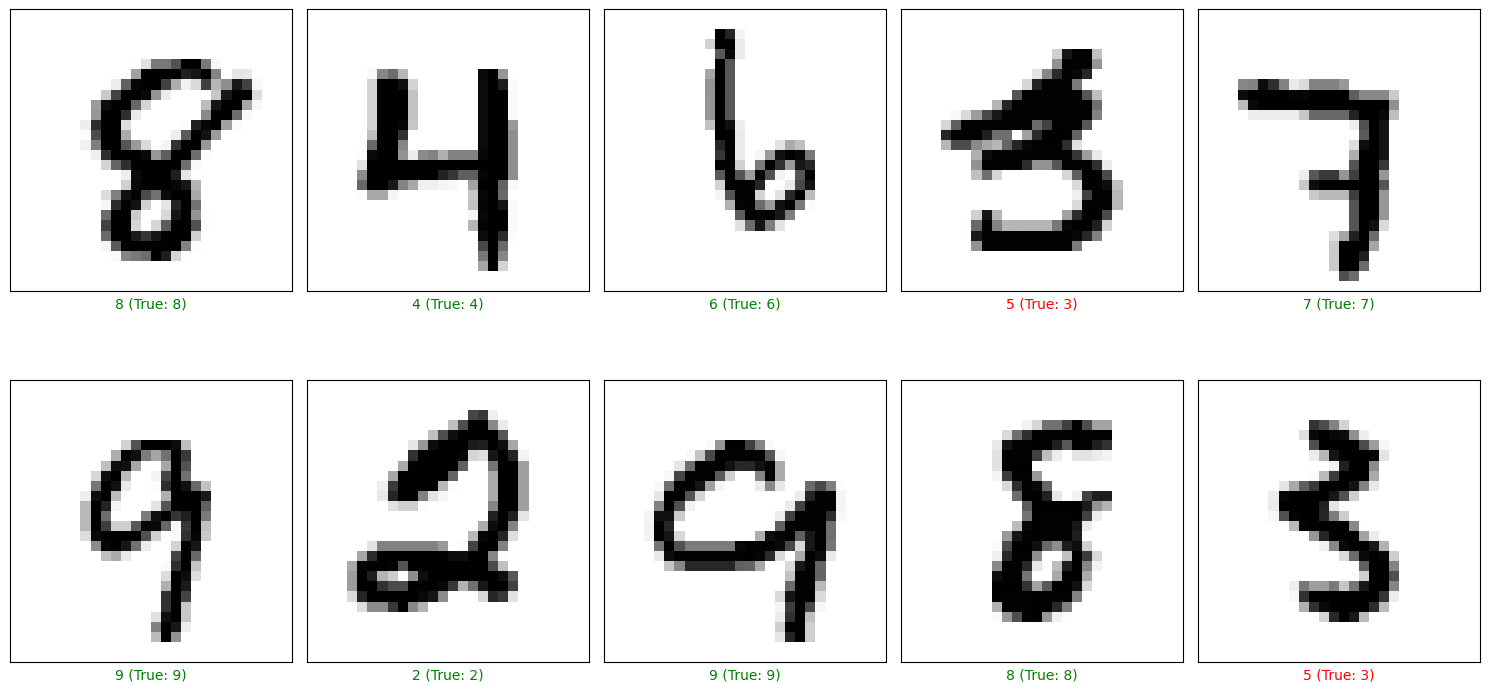

In [214]:
test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

Test Loss: 0.2867, Test Accuracy: 0.9187


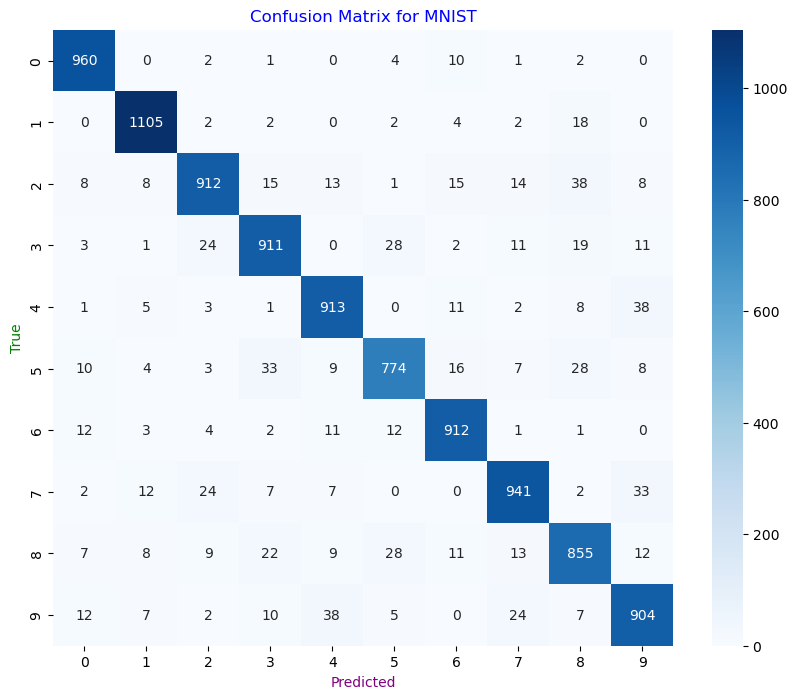

In [215]:
test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")

# Analysis of Model Hyperparameters and Their Impact on Performance

## 1. Changing Learning Rates
### Experiment
- Evaluate the model's performance using at least **4 different learning rates**.
- Common values to test:
  - **0.1**: High learning rate, may lead to unstable training.
  - **0.05**: Slightly lower but still aggressive learning rate.
  - **0.01**: Default learning rate.
  - **0.001**: Smaller learning rate, useful for fine-tuning.
  - **0.0001**: Very small learning rate, may result in slower convergence.

### Expected Observations
- **High Learning Rate**: Model might diverge or oscillate without converging to a minimum.
- **Optimal Learning Rate**: Model converges efficiently with good performance on both training and validation datasets.
- **Low Learning Rate**: Training takes longer and might get stuck in local minima.

---


Epoch 1/50, Train Loss: 0.5073, Train Accuracy: 87.04%, Val Loss: 0.3651, Val Accuracy: 90.07%
Epoch 2/50, Train Loss: 0.3489, Train Accuracy: 90.34%, Val Loss: 0.3298, Val Accuracy: 90.99%
Epoch 3/50, Train Loss: 0.3237, Train Accuracy: 90.90%, Val Loss: 0.3154, Val Accuracy: 91.31%
Epoch 4/50, Train Loss: 0.3099, Train Accuracy: 91.41%, Val Loss: 0.3053, Val Accuracy: 91.40%
Epoch 5/50, Train Loss: 0.3013, Train Accuracy: 91.62%, Val Loss: 0.2989, Val Accuracy: 91.73%
Epoch 6/50, Train Loss: 0.2945, Train Accuracy: 91.83%, Val Loss: 0.2976, Val Accuracy: 91.92%
Epoch 7/50, Train Loss: 0.2895, Train Accuracy: 91.95%, Val Loss: 0.2923, Val Accuracy: 91.97%
Epoch 8/50, Train Loss: 0.2857, Train Accuracy: 92.04%, Val Loss: 0.2923, Val Accuracy: 91.75%
Epoch 9/50, Train Loss: 0.2824, Train Accuracy: 92.14%, Val Loss: 0.2896, Val Accuracy: 91.91%
Epoch 10/50, Train Loss: 0.2796, Train Accuracy: 92.27%, Val Loss: 0.2874, Val Accuracy: 92.03%
Epoch 11/50, Train Loss: 0.2770, Train Accuracy: 

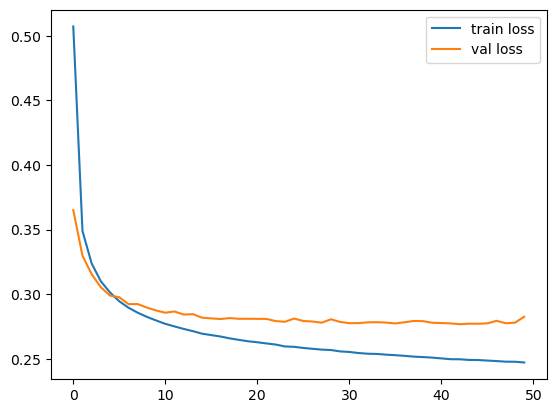

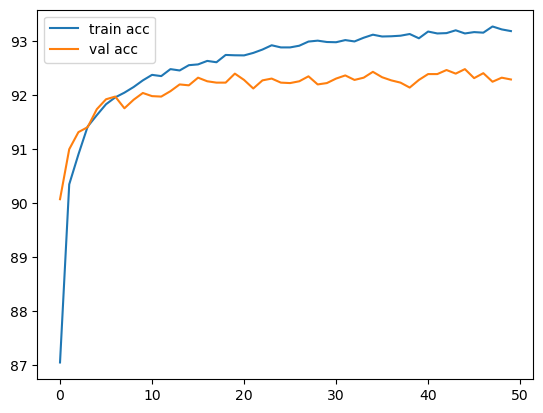

In [216]:
# 0.1 learning rate
train_loader, val_loader, test_loader = data_preperation(batch_size=64)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

Epoch 1/50, Train Loss: 0.6139, Train Accuracy: 85.48%, Val Loss: 0.4177, Val Accuracy: 88.90%
Epoch 2/50, Train Loss: 0.3912, Train Accuracy: 89.44%, Val Loss: 0.3636, Val Accuracy: 90.08%
Epoch 3/50, Train Loss: 0.3556, Train Accuracy: 90.15%, Val Loss: 0.3416, Val Accuracy: 90.78%
Epoch 4/50, Train Loss: 0.3370, Train Accuracy: 90.58%, Val Loss: 0.3285, Val Accuracy: 90.83%
Epoch 5/50, Train Loss: 0.3250, Train Accuracy: 90.96%, Val Loss: 0.3202, Val Accuracy: 91.19%
Epoch 6/50, Train Loss: 0.3164, Train Accuracy: 91.23%, Val Loss: 0.3141, Val Accuracy: 91.19%
Epoch 7/50, Train Loss: 0.3097, Train Accuracy: 91.37%, Val Loss: 0.3087, Val Accuracy: 91.59%
Epoch 8/50, Train Loss: 0.3047, Train Accuracy: 91.54%, Val Loss: 0.3047, Val Accuracy: 91.54%
Epoch 9/50, Train Loss: 0.3001, Train Accuracy: 91.61%, Val Loss: 0.3005, Val Accuracy: 91.79%
Epoch 10/50, Train Loss: 0.2965, Train Accuracy: 91.71%, Val Loss: 0.3000, Val Accuracy: 91.65%
Epoch 11/50, Train Loss: 0.2935, Train Accuracy: 

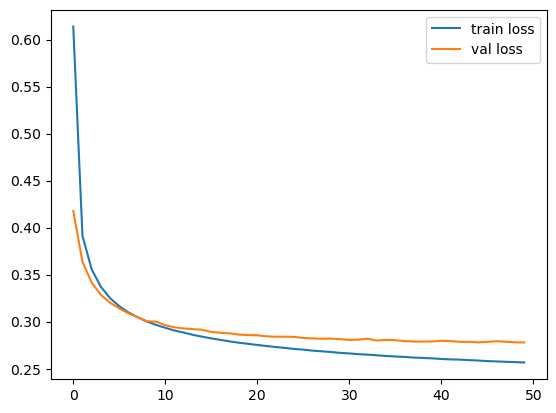

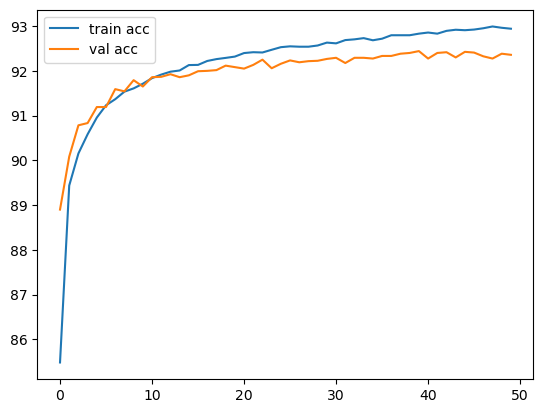

In [217]:
# 0.05 learning rate
train_loader, val_loader, test_loader = data_preperation(batch_size=64)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

Epoch 1/50, Train Loss: 1.9755, Train Accuracy: 51.12%, Val Loss: 1.7003, Val Accuracy: 73.14%
Epoch 2/50, Train Loss: 1.5106, Train Accuracy: 76.45%, Val Loss: 1.3520, Val Accuracy: 78.53%
Epoch 3/50, Train Loss: 1.2383, Train Accuracy: 79.81%, Val Loss: 1.1414, Val Accuracy: 80.48%
Epoch 4/50, Train Loss: 1.0685, Train Accuracy: 81.36%, Val Loss: 1.0047, Val Accuracy: 81.81%
Epoch 5/50, Train Loss: 0.9547, Train Accuracy: 82.55%, Val Loss: 0.9098, Val Accuracy: 82.83%
Epoch 6/50, Train Loss: 0.8735, Train Accuracy: 83.20%, Val Loss: 0.8401, Val Accuracy: 83.42%
Epoch 7/50, Train Loss: 0.8127, Train Accuracy: 83.72%, Val Loss: 0.7866, Val Accuracy: 83.94%
Epoch 8/50, Train Loss: 0.7653, Train Accuracy: 84.15%, Val Loss: 0.7444, Val Accuracy: 84.18%
Epoch 9/50, Train Loss: 0.7271, Train Accuracy: 84.53%, Val Loss: 0.7098, Val Accuracy: 84.61%
Epoch 10/50, Train Loss: 0.6958, Train Accuracy: 84.90%, Val Loss: 0.6811, Val Accuracy: 84.92%
Epoch 11/50, Train Loss: 0.6695, Train Accuracy: 

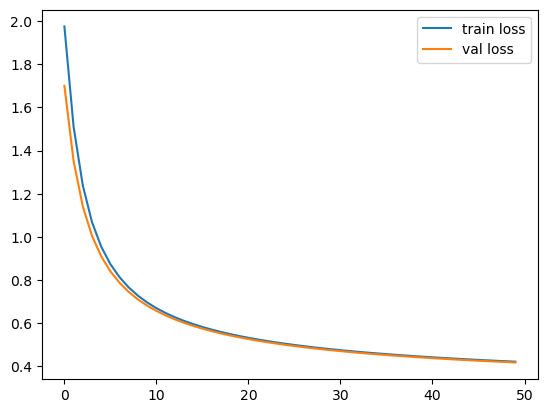

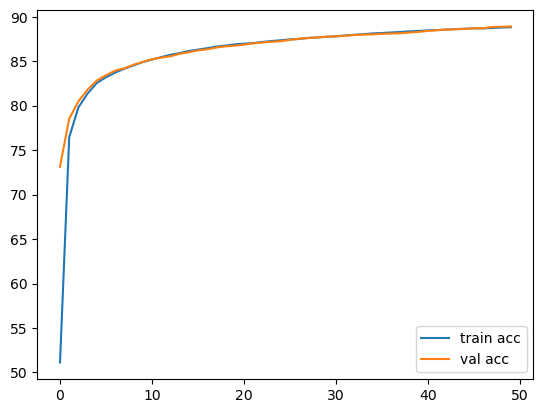

In [218]:
# 0.001 learning rate
train_loader, val_loader, test_loader = data_preperation(batch_size=64)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

Epoch 1/50, Train Loss: 2.2905, Train Accuracy: 11.82%, Val Loss: 2.2534, Val Accuracy: 16.30%
Epoch 2/50, Train Loss: 2.2139, Train Accuracy: 22.51%, Val Loss: 2.1794, Val Accuracy: 28.51%
Epoch 3/50, Train Loss: 2.1418, Train Accuracy: 34.61%, Val Loss: 2.1096, Val Accuracy: 40.56%
Epoch 4/50, Train Loss: 2.0737, Train Accuracy: 45.91%, Val Loss: 2.0436, Val Accuracy: 50.86%
Epoch 5/50, Train Loss: 2.0094, Train Accuracy: 55.00%, Val Loss: 1.9812, Val Accuracy: 58.42%
Epoch 6/50, Train Loss: 1.9485, Train Accuracy: 61.36%, Val Loss: 1.9220, Val Accuracy: 63.42%
Epoch 7/50, Train Loss: 1.8909, Train Accuracy: 65.15%, Val Loss: 1.8661, Val Accuracy: 66.62%
Epoch 8/50, Train Loss: 1.8364, Train Accuracy: 67.79%, Val Loss: 1.8131, Val Accuracy: 68.80%
Epoch 9/50, Train Loss: 1.7849, Train Accuracy: 69.49%, Val Loss: 1.7631, Val Accuracy: 70.21%
Epoch 10/50, Train Loss: 1.7361, Train Accuracy: 70.83%, Val Loss: 1.7157, Val Accuracy: 71.34%
Epoch 11/50, Train Loss: 1.6900, Train Accuracy: 

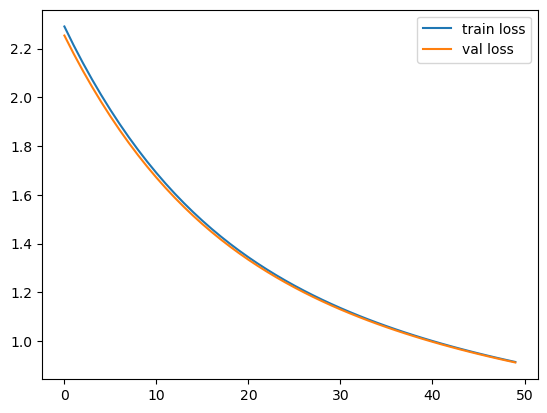

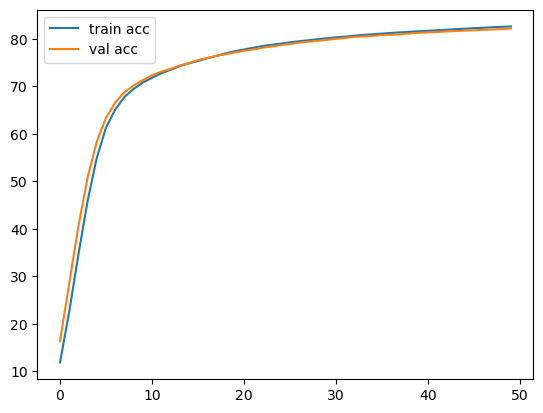

In [219]:
# 0.0001 learning rate
train_loader, val_loader, test_loader = data_preperation(batch_size=64)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

## 2. Changing Batch Sizes
### Experiment
- Evaluate the model's performance using at least **4 different batch sizes**.
- Common values to test:
  - **16**: Small batch size, leads to more updates but can be noisy.
  - **32**: Moderate batch size, balances updates and noise.
  - **64**: Default batch size.
  - **128**: Large batch size, fewer updates per epoch but smoother gradients.
  - **256**: Very large batch size, further reduces gradient noise but may require more epochs.

### Expected Observations
- **Small Batch Size**: Can lead to faster convergence but higher variance in the loss curve.
- **Large Batch Size**: Produces smoother gradients but might require more epochs to converge.

---

Epoch 1/50, Train Loss: 0.6539, Train Accuracy: 85.12%, Val Loss: 0.4423, Val Accuracy: 88.33%
Epoch 2/50, Train Loss: 0.4083, Train Accuracy: 89.05%, Val Loss: 0.3796, Val Accuracy: 89.47%
Epoch 3/50, Train Loss: 0.3685, Train Accuracy: 89.83%, Val Loss: 0.3536, Val Accuracy: 90.14%
Epoch 4/50, Train Loss: 0.3480, Train Accuracy: 90.34%, Val Loss: 0.3389, Val Accuracy: 90.58%
Epoch 5/50, Train Loss: 0.3347, Train Accuracy: 90.66%, Val Loss: 0.3286, Val Accuracy: 90.80%
Epoch 6/50, Train Loss: 0.3254, Train Accuracy: 90.90%, Val Loss: 0.3209, Val Accuracy: 91.05%
Epoch 7/50, Train Loss: 0.3180, Train Accuracy: 91.14%, Val Loss: 0.3161, Val Accuracy: 91.33%
Epoch 8/50, Train Loss: 0.3123, Train Accuracy: 91.29%, Val Loss: 0.3114, Val Accuracy: 91.33%
Epoch 9/50, Train Loss: 0.3075, Train Accuracy: 91.46%, Val Loss: 0.3080, Val Accuracy: 91.52%
Epoch 10/50, Train Loss: 0.3034, Train Accuracy: 91.58%, Val Loss: 0.3052, Val Accuracy: 91.64%
Epoch 11/50, Train Loss: 0.3001, Train Accuracy: 

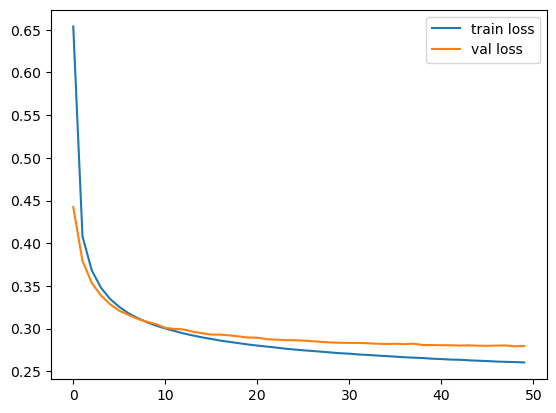

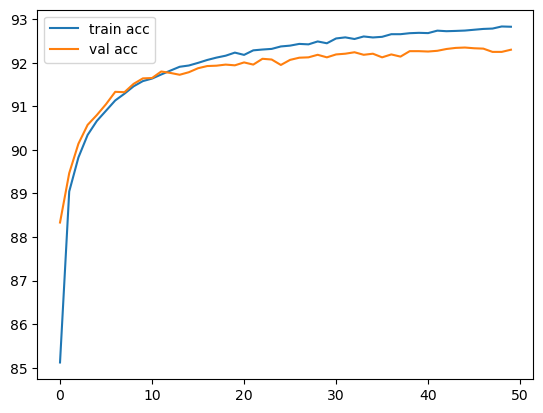

In [220]:
# 16 batch_size
batch_size = 16
train_loader, val_loader, test_loader = data_preperation(batch_size)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

Epoch 1/50, Train Loss: 0.8293, Train Accuracy: 82.31%, Val Loss: 0.5342, Val Accuracy: 86.73%
Epoch 2/50, Train Loss: 0.4807, Train Accuracy: 87.77%, Val Loss: 0.4403, Val Accuracy: 88.42%
Epoch 3/50, Train Loss: 0.4214, Train Accuracy: 88.84%, Val Loss: 0.4016, Val Accuracy: 89.17%
Epoch 4/50, Train Loss: 0.3922, Train Accuracy: 89.40%, Val Loss: 0.3786, Val Accuracy: 89.78%
Epoch 5/50, Train Loss: 0.3735, Train Accuracy: 89.80%, Val Loss: 0.3640, Val Accuracy: 90.03%
Epoch 6/50, Train Loss: 0.3604, Train Accuracy: 90.04%, Val Loss: 0.3533, Val Accuracy: 90.22%
Epoch 7/50, Train Loss: 0.3505, Train Accuracy: 90.32%, Val Loss: 0.3442, Val Accuracy: 90.51%
Epoch 8/50, Train Loss: 0.3426, Train Accuracy: 90.45%, Val Loss: 0.3378, Val Accuracy: 90.63%
Epoch 9/50, Train Loss: 0.3360, Train Accuracy: 90.62%, Val Loss: 0.3331, Val Accuracy: 90.89%
Epoch 10/50, Train Loss: 0.3307, Train Accuracy: 90.77%, Val Loss: 0.3281, Val Accuracy: 90.92%
Epoch 11/50, Train Loss: 0.3260, Train Accuracy: 

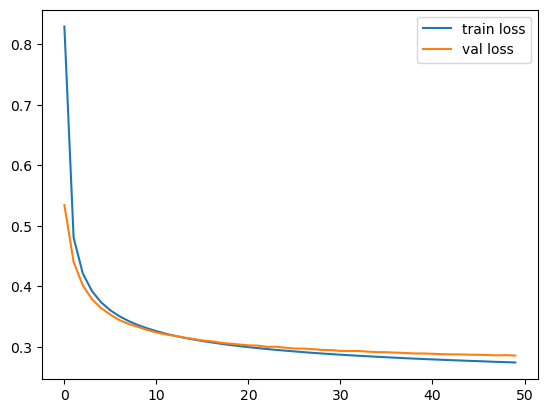

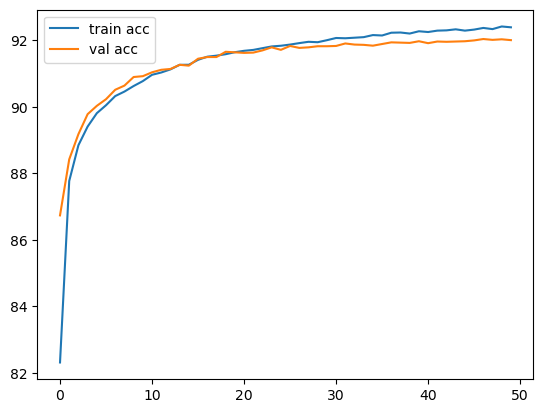

In [221]:
# 32 batch_size
batch_size = 32
train_loader, val_loader, test_loader = data_preperation(batch_size)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

Epoch 1/50, Train Loss: 1.3410, Train Accuracy: 74.79%, Val Loss: 0.9059, Val Accuracy: 82.59%
Epoch 2/50, Train Loss: 0.7718, Train Accuracy: 84.33%, Val Loss: 0.6795, Val Accuracy: 84.92%
Epoch 3/50, Train Loss: 0.6283, Train Accuracy: 85.74%, Val Loss: 0.5867, Val Accuracy: 86.14%
Epoch 4/50, Train Loss: 0.5591, Train Accuracy: 86.61%, Val Loss: 0.5338, Val Accuracy: 86.97%
Epoch 5/50, Train Loss: 0.5169, Train Accuracy: 87.17%, Val Loss: 0.4993, Val Accuracy: 87.36%
Epoch 6/50, Train Loss: 0.4878, Train Accuracy: 87.62%, Val Loss: 0.4742, Val Accuracy: 87.77%
Epoch 7/50, Train Loss: 0.4664, Train Accuracy: 88.04%, Val Loss: 0.4553, Val Accuracy: 88.14%
Epoch 8/50, Train Loss: 0.4497, Train Accuracy: 88.31%, Val Loss: 0.4402, Val Accuracy: 88.44%
Epoch 9/50, Train Loss: 0.4362, Train Accuracy: 88.58%, Val Loss: 0.4282, Val Accuracy: 88.65%
Epoch 10/50, Train Loss: 0.4250, Train Accuracy: 88.82%, Val Loss: 0.4180, Val Accuracy: 88.87%
Epoch 11/50, Train Loss: 0.4156, Train Accuracy: 

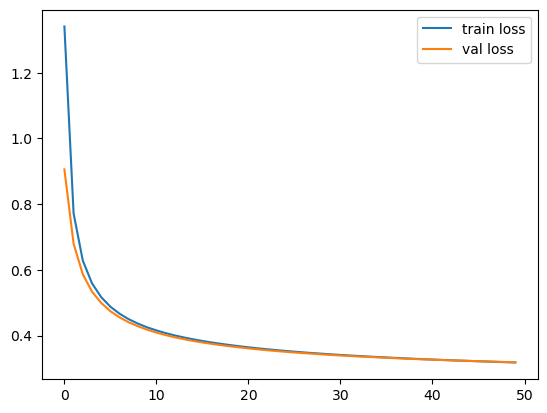

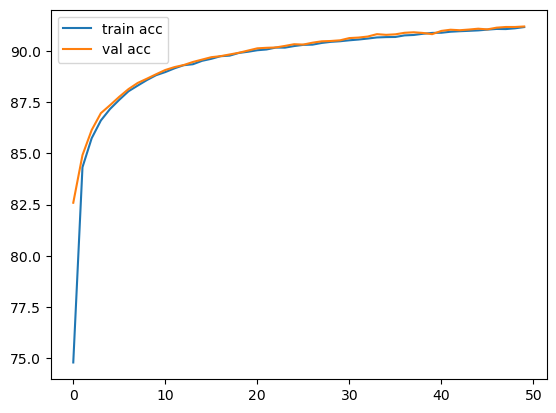

In [222]:
# 128 batch_size
batch_size = 128
train_loader, val_loader, test_loader = data_preperation(batch_size)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

Epoch 1/50, Train Loss: 1.6720, Train Accuracy: 67.04%, Val Loss: 1.2384, Val Accuracy: 78.80%
Epoch 2/50, Train Loss: 1.0468, Train Accuracy: 81.50%, Val Loss: 0.9111, Val Accuracy: 82.17%
Epoch 3/50, Train Loss: 0.8283, Train Accuracy: 83.58%, Val Loss: 0.7650, Val Accuracy: 83.72%
Epoch 4/50, Train Loss: 0.7187, Train Accuracy: 84.79%, Val Loss: 0.6815, Val Accuracy: 84.74%
Epoch 5/50, Train Loss: 0.6518, Train Accuracy: 85.54%, Val Loss: 0.6268, Val Accuracy: 85.62%
Epoch 6/50, Train Loss: 0.6057, Train Accuracy: 86.13%, Val Loss: 0.5877, Val Accuracy: 85.94%
Epoch 7/50, Train Loss: 0.5722, Train Accuracy: 86.50%, Val Loss: 0.5581, Val Accuracy: 86.33%
Epoch 8/50, Train Loss: 0.5463, Train Accuracy: 86.89%, Val Loss: 0.5346, Val Accuracy: 86.86%
Epoch 9/50, Train Loss: 0.5256, Train Accuracy: 87.14%, Val Loss: 0.5158, Val Accuracy: 87.05%
Epoch 10/50, Train Loss: 0.5085, Train Accuracy: 87.40%, Val Loss: 0.4998, Val Accuracy: 87.34%
Epoch 11/50, Train Loss: 0.4939, Train Accuracy: 

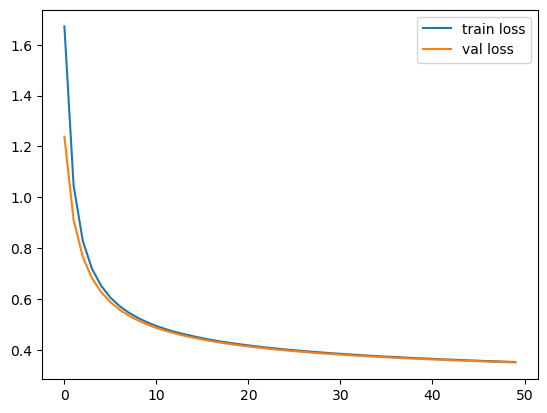

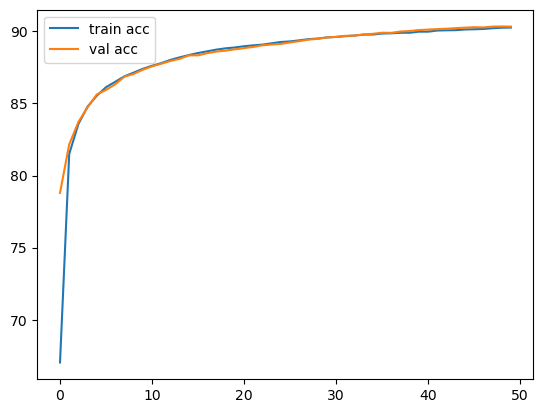

In [223]:
# 256 batch_size
batch_size = 256
train_loader, val_loader, test_loader = data_preperation(batch_size)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

## 3. Adding L2 Regularization
### Experiment
- Incorporate L2 regularization by setting a **`weight_decay` parameter** in the optimizer.
- Test with different `weight_decay` values, such as:
  - **0.0**: No regularization is default.
  - **0.0001**: Very light regularization.
  - **0.001**: Light regularization.
  - **0.01**: Moderate regularization.
  - **0.1**: Strong regularization.

### Expected Observations
- **No Regularization**: Model might overfit to the training data.
- **Light Regularization**: Balances model complexity and generalization.
- **Strong Regularization**: Might underfit the data, leading to poor training accuracy.

---

Epoch 1/50, Train Loss: 1.0604, Train Accuracy: 79.25%, Val Loss: 0.6812, Val Accuracy: 84.93%
Epoch 2/50, Train Loss: 0.5953, Train Accuracy: 86.21%, Val Loss: 0.5342, Val Accuracy: 86.80%
Epoch 3/50, Train Loss: 0.5036, Train Accuracy: 87.53%, Val Loss: 0.4749, Val Accuracy: 87.81%
Epoch 4/50, Train Loss: 0.4592, Train Accuracy: 88.20%, Val Loss: 0.4407, Val Accuracy: 88.30%
Epoch 5/50, Train Loss: 0.4317, Train Accuracy: 88.65%, Val Loss: 0.4180, Val Accuracy: 88.83%
Epoch 6/50, Train Loss: 0.4126, Train Accuracy: 89.05%, Val Loss: 0.4019, Val Accuracy: 89.11%
Epoch 7/50, Train Loss: 0.3982, Train Accuracy: 89.35%, Val Loss: 0.3895, Val Accuracy: 89.45%
Epoch 8/50, Train Loss: 0.3871, Train Accuracy: 89.62%, Val Loss: 0.3791, Val Accuracy: 89.63%
Epoch 9/50, Train Loss: 0.3779, Train Accuracy: 89.77%, Val Loss: 0.3711, Val Accuracy: 89.95%
Epoch 10/50, Train Loss: 0.3702, Train Accuracy: 89.94%, Val Loss: 0.3645, Val Accuracy: 90.02%
Epoch 11/50, Train Loss: 0.3637, Train Accuracy: 

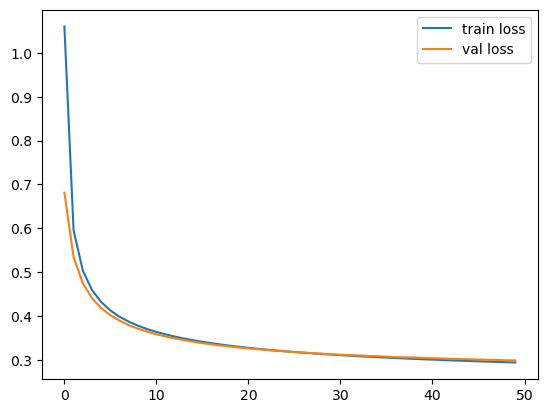

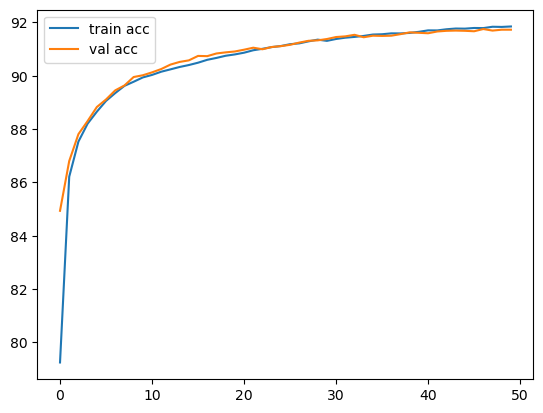

In [224]:
# 0.0001 regulariztion
train_loader, val_loader, test_loader = data_preperation(batch_size=64)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

Epoch 1/50, Train Loss: 1.0621, Train Accuracy: 78.98%, Val Loss: 0.6818, Val Accuracy: 84.81%
Epoch 2/50, Train Loss: 0.5964, Train Accuracy: 86.21%, Val Loss: 0.5363, Val Accuracy: 86.89%
Epoch 3/50, Train Loss: 0.5052, Train Accuracy: 87.46%, Val Loss: 0.4771, Val Accuracy: 87.78%
Epoch 4/50, Train Loss: 0.4613, Train Accuracy: 88.19%, Val Loss: 0.4436, Val Accuracy: 88.34%
Epoch 5/50, Train Loss: 0.4343, Train Accuracy: 88.70%, Val Loss: 0.4214, Val Accuracy: 88.71%
Epoch 6/50, Train Loss: 0.4156, Train Accuracy: 88.99%, Val Loss: 0.4052, Val Accuracy: 89.22%
Epoch 7/50, Train Loss: 0.4016, Train Accuracy: 89.31%, Val Loss: 0.3932, Val Accuracy: 89.48%
Epoch 8/50, Train Loss: 0.3907, Train Accuracy: 89.53%, Val Loss: 0.3837, Val Accuracy: 89.77%
Epoch 9/50, Train Loss: 0.3818, Train Accuracy: 89.73%, Val Loss: 0.3753, Val Accuracy: 89.92%
Epoch 10/50, Train Loss: 0.3745, Train Accuracy: 89.87%, Val Loss: 0.3687, Val Accuracy: 90.13%
Epoch 11/50, Train Loss: 0.3682, Train Accuracy: 

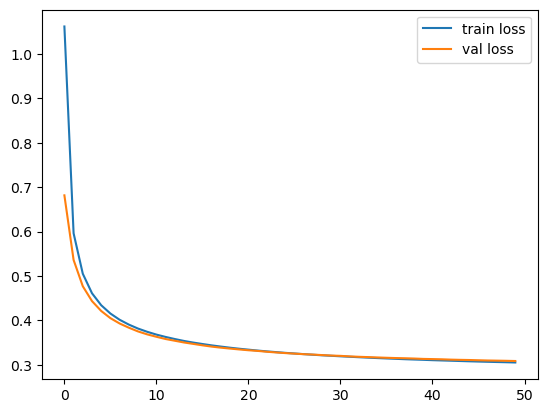

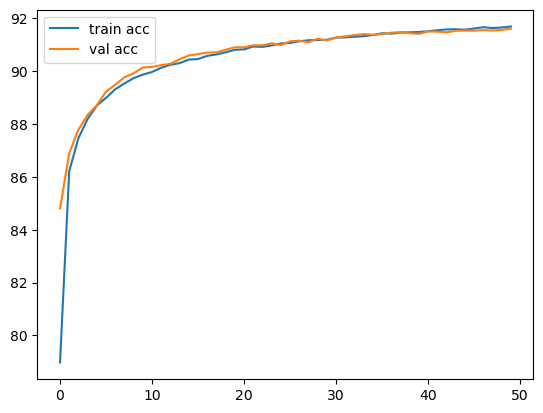

In [225]:
# 0.001 regulariztion
train_loader, val_loader, test_loader = data_preperation(batch_size=64)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

Epoch 1/50, Train Loss: 1.0799, Train Accuracy: 78.45%, Val Loss: 0.6987, Val Accuracy: 84.82%
Epoch 2/50, Train Loss: 0.6160, Train Accuracy: 86.08%, Val Loss: 0.5590, Val Accuracy: 86.76%
Epoch 3/50, Train Loss: 0.5309, Train Accuracy: 87.31%, Val Loss: 0.5056, Val Accuracy: 87.57%
Epoch 4/50, Train Loss: 0.4921, Train Accuracy: 88.10%, Val Loss: 0.4772, Val Accuracy: 88.23%
Epoch 5/50, Train Loss: 0.4697, Train Accuracy: 88.49%, Val Loss: 0.4591, Val Accuracy: 88.58%
Epoch 6/50, Train Loss: 0.4549, Train Accuracy: 88.75%, Val Loss: 0.4477, Val Accuracy: 88.88%
Epoch 7/50, Train Loss: 0.4446, Train Accuracy: 88.97%, Val Loss: 0.4385, Val Accuracy: 89.06%
Epoch 8/50, Train Loss: 0.4373, Train Accuracy: 89.17%, Val Loss: 0.4323, Val Accuracy: 89.17%
Epoch 9/50, Train Loss: 0.4318, Train Accuracy: 89.31%, Val Loss: 0.4277, Val Accuracy: 89.45%
Epoch 10/50, Train Loss: 0.4274, Train Accuracy: 89.45%, Val Loss: 0.4235, Val Accuracy: 89.55%
Epoch 11/50, Train Loss: 0.4239, Train Accuracy: 

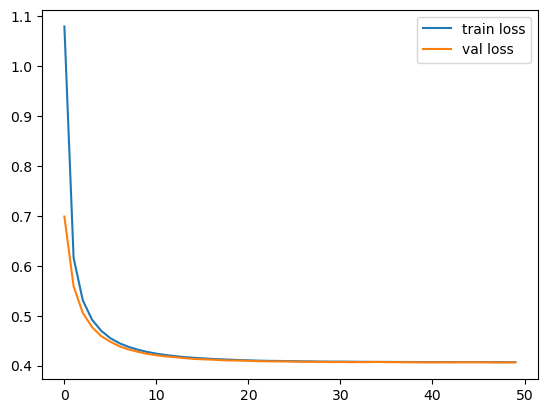

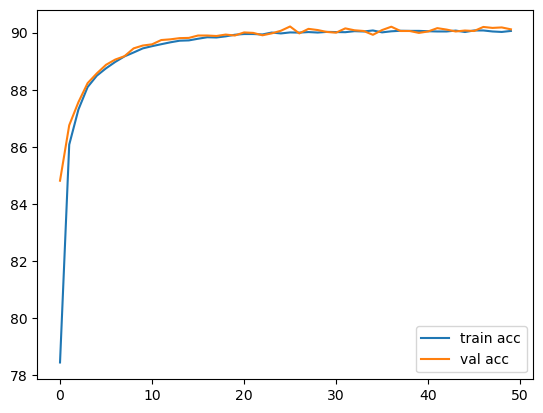

In [226]:
# 0.01 regulariztion
train_loader, val_loader, test_loader = data_preperation(batch_size=64)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

Epoch 1/50, Train Loss: 1.1523, Train Accuracy: 79.19%, Val Loss: 0.8512, Val Accuracy: 84.25%
Epoch 2/50, Train Loss: 0.8087, Train Accuracy: 85.12%, Val Loss: 0.7857, Val Accuracy: 85.61%
Epoch 3/50, Train Loss: 0.7792, Train Accuracy: 85.77%, Val Loss: 0.7748, Val Accuracy: 85.93%
Epoch 4/50, Train Loss: 0.7731, Train Accuracy: 85.92%, Val Loss: 0.7719, Val Accuracy: 86.01%
Epoch 5/50, Train Loss: 0.7718, Train Accuracy: 85.96%, Val Loss: 0.7712, Val Accuracy: 86.08%
Epoch 6/50, Train Loss: 0.7714, Train Accuracy: 86.03%, Val Loss: 0.7712, Val Accuracy: 85.59%
Epoch 7/50, Train Loss: 0.7710, Train Accuracy: 86.01%, Val Loss: 0.7713, Val Accuracy: 85.94%
Epoch 8/50, Train Loss: 0.7713, Train Accuracy: 86.08%, Val Loss: 0.7707, Val Accuracy: 85.56%
Epoch 9/50, Train Loss: 0.7708, Train Accuracy: 86.05%, Val Loss: 0.7708, Val Accuracy: 85.86%
Epoch 10/50, Train Loss: 0.7709, Train Accuracy: 86.00%, Val Loss: 0.7715, Val Accuracy: 86.17%
Epoch 11/50, Train Loss: 0.7710, Train Accuracy: 

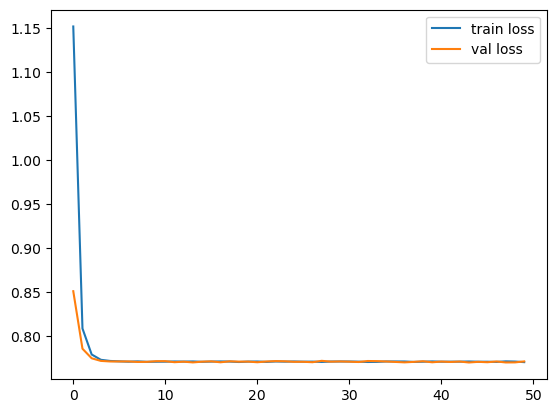

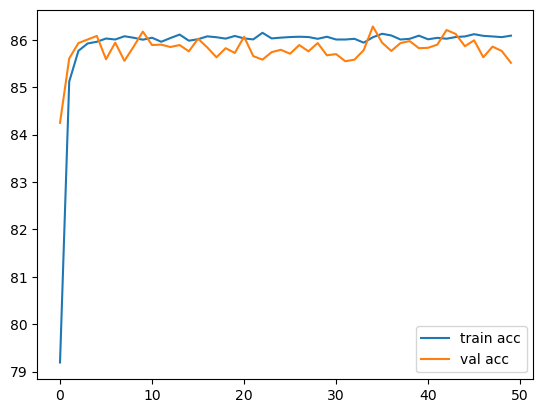

In [227]:
# 0.1 regulariztion
train_loader, val_loader, test_loader = data_preperation(batch_size=64)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.1) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

# Bonus: Feedforward Neural Network

### Data Loading

In [228]:
# importing the built in mnist dataset from kersas
(X_train_full,y_train_full),(X_test,y_test)=keras.datasets.mnist.load_data()
# combine training and testing data
X_combined = np.concatenate([X_train_full,X_test],axis=0)
y_combined = np.concatenate([y_train_full,y_test],axis=0)

### Data Preparation

In [229]:
# normalize pixel from [0,255] values to [0, 1]
X_combined = X_combined / 255.0


In [230]:
# reshape data to suit the fully connected layer in neural network input into a 1d array of size 28*28
X_combined = X_combined.reshape(-1,28*28)

In [231]:
# split dataset into training, validation, and testing sets (60/20/20 split)
X_train, X_remaining, y_train, y_remaining = train_test_split(X_combined,y_combined,test_size=0.4,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remaining,y_remaining,test_size=0.5,random_state=42)

## From scratch

In [232]:
class FNN_FROM_SCRATCH:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.layers = []
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        prev_size = input_size
        
        # initialize weights and biases for each layer
        for hidden_size in hidden_sizes:
            W = np.random.rand(hidden_size, prev_size) - 0.5
            b = np.random.rand(hidden_size, 1) - 0.5
            self.layers.append((W, b))
            prev_size = hidden_size
        
        # output layer
        W_out = np.random.rand(output_size, prev_size) - 0.5
        b_out = np.random.rand(output_size, 1) - 0.5
        self.layers.append((W_out, b_out))

    # relu function formula is f(x) = max(0,x)
    def ReLU(self, Z):
        return np.maximum(0, Z)
        
    # relu derivative in back propagation
    def ReLU_deriv(self, Z):
        return (Z > 0).astype(float)
    
    # softmax --> convert score to probabilities
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  
        return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

    # forward propagation
    def forward_prop(self, X):
        activations = [X]
        Zs = []
        
        # forward pass through all layers
        for i, (W, b) in enumerate(self.layers[:-1]):
            Z = np.dot(W, activations[-1]) + b
            A = self.ReLU(Z)
            activations.append(A)
            Zs.append(Z)
        
        # output layer
        W_out, b_out = self.layers[-1]
        Z_out = np.dot(W_out, activations[-1]) + b_out
        A_out = self.softmax(Z_out)
        activations.append(A_out)
        Zs.append(Z_out)
        
        return activations, Zs

    # one hot encoding
    def one_hot(self, Y, num_classes=10):
        # Y is expected to be 1D (class labels), so we convert to one-hot encoded 2D array
        one_hot_Y = np.zeros((num_classes, Y.size))
        one_hot_Y[Y, np.arange(Y.size)] = 1
        return one_hot_Y

    # backward propagation
    def backward_prop(self, activations, Zs, X, Y):
        m = X.shape[1]
        one_hot_Y = self.one_hot(Y)
        
        # backpropagation through output layer
        dA = activations[-1] - one_hot_Y
        dW = np.dot(dA, activations[-2].T) / m
        db = np.sum(dA, axis=1, keepdims=True) / m
        grads = [(dW, db)]
        
        # backpropagation through hidden layers
        for i in range(len(self.layers) - 2, -1, -1):
            dZ = np.dot(self.layers[i + 1][0].T, dA) * self.ReLU_deriv(Zs[i])
            dW = np.dot(dZ, activations[i].T) / m
            db = np.sum(dZ, axis=1, keepdims=True) / m
            grads.insert(0, (dW, db))
            dA = dZ  # for the next iteration
        
        return grads

    # update parameters using gradient descent
    def update_params(self, grads, alpha):
        for i in range(len(self.layers)):
            dW, db = grads[i]
            self.layers[i] = (self.layers[i][0] - alpha * dW, self.layers[i][1] - alpha * db)
        return self.layers

    # model predictions
    def get_predictions(self, A2):
        return np.argmax(A2, axis=0)

    # compute accuracy
    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size

    # gradient descent
    def gradient_descent(self, X, Y, alpha, iterations, X_val, y_val):
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
        # Convert Y to one-hot encoding
        Y_one_hot = self.one_hot(Y)
        y_val_one_hot = self.one_hot(y_val)
    
        for i in range(iterations):
            # forward propagation for training data
            activations, Zs = self.forward_prop(X)
            grads = self.backward_prop(activations, Zs, X, Y)
            self.update_params(grads, alpha)
    
            # calculate training loss and accuracy
            train_predictions = self.get_predictions(activations[-1])
            train_accuracy = self.get_accuracy(train_predictions, Y)
            train_loss = self.loss_function(activations[-1], Y_one_hot)
    
            # track history
            history['loss'].append(train_loss)
            history['accuracy'].append(train_accuracy)
    
            # forward propagation for validation data
            activations_val, _ = self.forward_prop(X_val)
            val_predictions = self.get_predictions(activations_val[-1])
            val_accuracy = self.get_accuracy(val_predictions, y_val)
            val_loss = self.loss_function(activations_val[-1], y_val_one_hot)
    
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)
    
            if i % 10 == 0:
                print(f"Iteration {i} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f}")
                print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")
    
        return history

    # loss function (cross-entropy loss)
    def loss_function(self, predictions, Y):
        # compute cross-entropy loss 
        m = Y.shape[1]
        log_probs = -np.log(predictions + 1e-10)
        loss = np.sum(np.multiply(log_probs, Y)) / m
        return loss


In [233]:
# hyper parameters
input_size = 784  # 28x28 images flattened
hidden_sizes = [128,64]  
output_size = 10 
learning_rate = 0.1 
iterations = 100

# init the model
model = FNN_FROM_SCRATCH(input_size, hidden_sizes, output_size)

# train the model using gradient descent
history = model.gradient_descent(X_train.T, y_train, learning_rate, iterations, X_val.T, y_val)

# make predictions on the test set
activations, _ = model.forward_prop(X_test.T)
y_pred = model.get_predictions(activations[-1])

# evaluate the model
accuracy = model.get_accuracy(y_pred, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))


Iteration 0 - Loss: 14.1881 - Accuracy: 0.1178
Validation Loss: 12.1456 - Validation Accuracy: 0.1171
Iteration 10 - Loss: 1.9722 - Accuracy: 0.4583
Validation Loss: 1.8838 - Validation Accuracy: 0.4677
Iteration 20 - Loss: 1.3105 - Accuracy: 0.6027
Validation Loss: 1.3048 - Validation Accuracy: 0.6024
Iteration 30 - Loss: 1.0521 - Accuracy: 0.6750
Validation Loss: 1.0613 - Validation Accuracy: 0.6709
Iteration 40 - Loss: 0.9044 - Accuracy: 0.7191
Validation Loss: 0.9203 - Validation Accuracy: 0.7137
Iteration 50 - Loss: 0.8085 - Accuracy: 0.7479
Validation Loss: 0.8282 - Validation Accuracy: 0.7431
Iteration 60 - Loss: 0.7398 - Accuracy: 0.7682
Validation Loss: 0.7621 - Validation Accuracy: 0.7639
Iteration 70 - Loss: 0.6877 - Accuracy: 0.7848
Validation Loss: 0.7119 - Validation Accuracy: 0.7800
Iteration 80 - Loss: 0.6465 - Accuracy: 0.7980
Validation Loss: 0.6722 - Validation Accuracy: 0.7940
Iteration 90 - Loss: 0.6127 - Accuracy: 0.8090
Validation Loss: 0.6397 - Validation Accura

### Analysis 

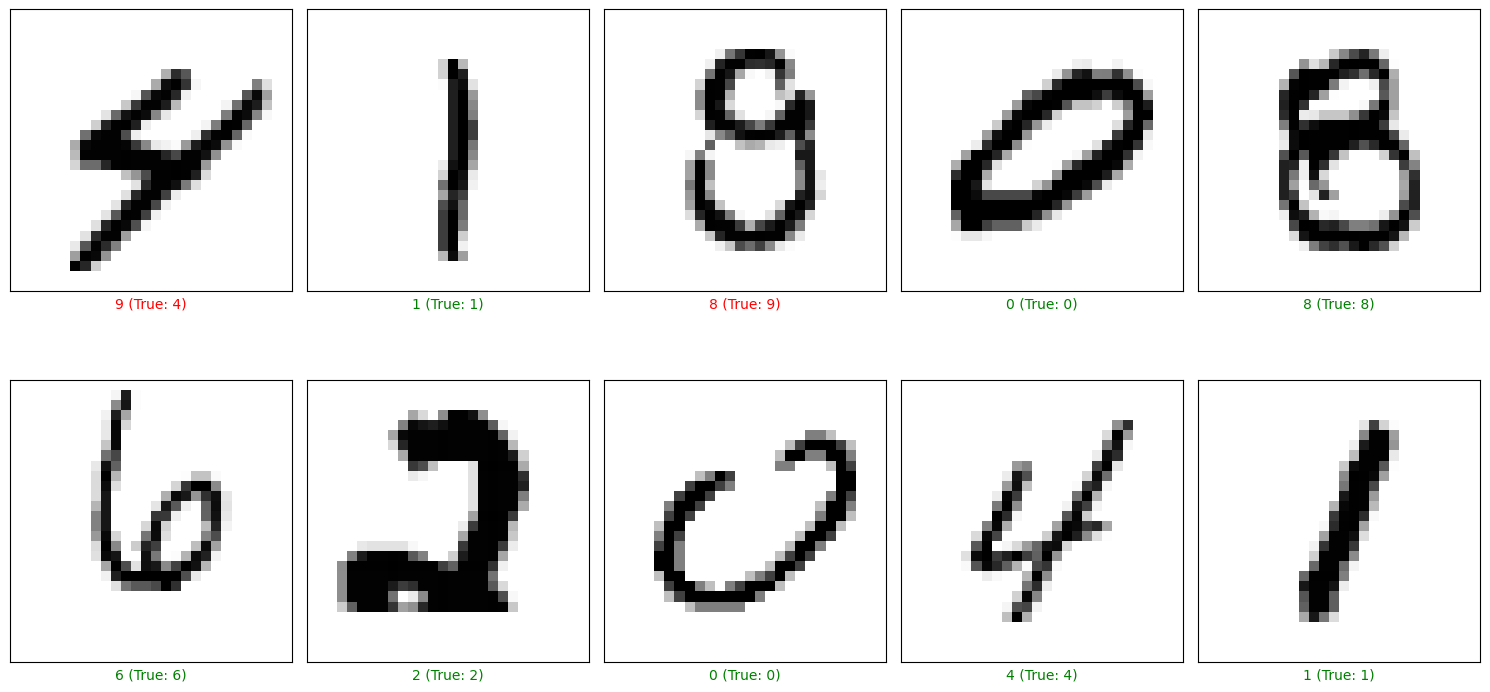

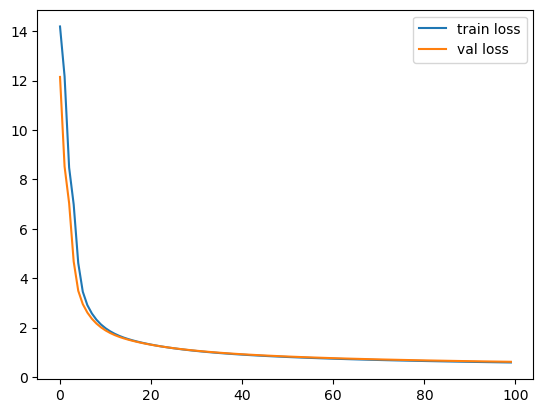

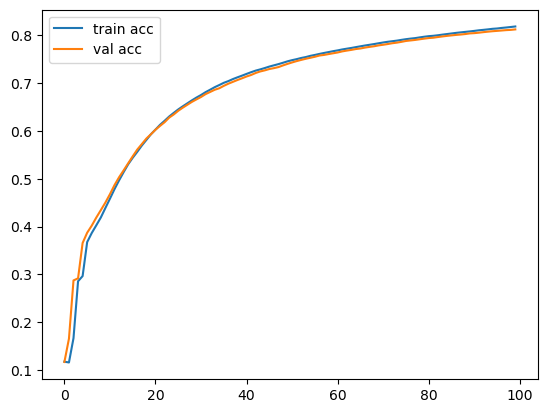

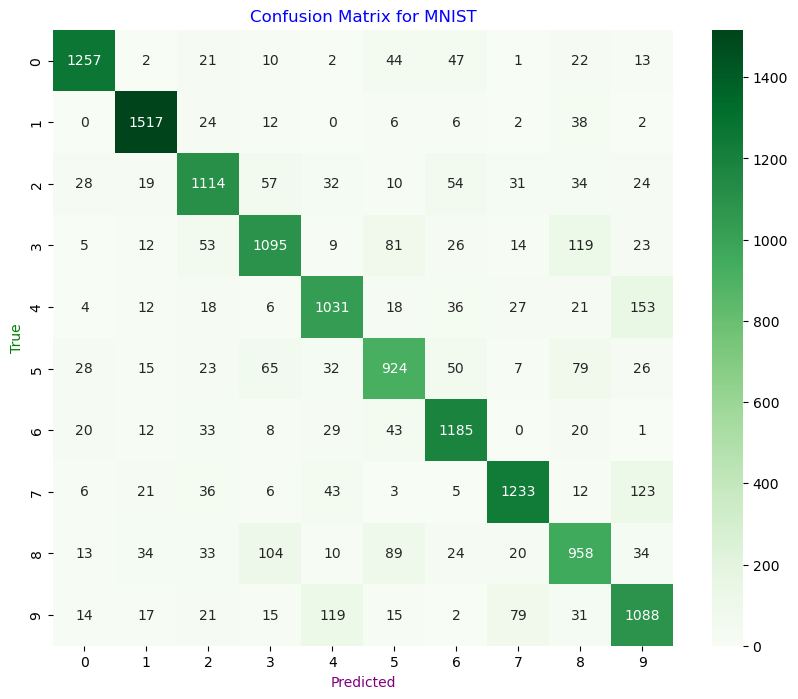

In [234]:
# visualization 
classes_names = [str(i) for i in range(10)]
visualize_predictions(y_pred, X_test, y_test, classes_names)  
acc_loss_plots(history)
plot_confusion_matrix(y_pred, y_test, classes_names, title="Confusion Matrix for MNIST", color="Greens")

## Using Tensorflow keras

### Model architecture

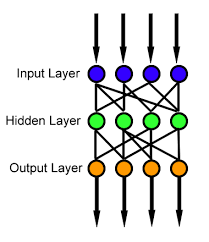
* Input layer: accepts flattened 28x28=784 features
* Hidden layer 1:
    - fully connected dense layer with 256 neurons.
    - relu activation
    - batch normalization
    - dropout 40% for regularization
* Hidden layer 2:
    - fully connected dense layer with 128 neurons.
    - relu activation
    - batch normalization
    - dropout 40% for regularization
* Hidden Layer 3:
    - fully connected dense layer with 64 neurons.
    - relu activation
    - batch normalization
    - dropout 30% for regularization
* Hidden Layer 4:
    - fully connected dense layer with 32 neurons.
    - relu activation
    - batch normalization
    - dropout 20% for regularization
* Output Layer:
    - fully connected dense layer with 10 neurons for the ten classes numbers 0-9
    - activation softmax for multi-class classification.

#### Why we used batch normalization?

Batch Normalization Concept

instead of just normalizing the input only and fed it into the network. We normalize the output of all the layers of the network.

It helps the network overcome the unstable gradients. As neural networks train, the outputs of neurons in each layer can shift due to updates in the weights.this occurs because the inputs to each layer depend on the outputs of the previous layers and as the parameters in earlier layers change so do the inputs to later layers. This shift slows down training because the layers constantly need to adjust to the new distributions. It often leads to issues like vanishing gradients or exploding gradients in deep networks making it hard for the network to learn effectively.

Batch normalization helps by reducing the amount of change in the distribution of layer inputs during training making the training process more stable and allowing higher learning rates.
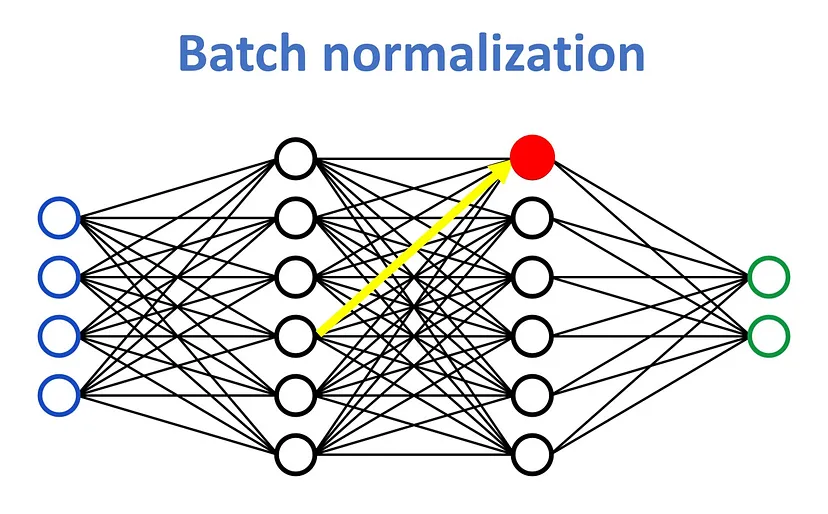

In [235]:
def build_model():
    """
    builds feedforward neural network for MNIST classification.
    returns a compiled keras model
    """
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(28*28,)),  # input layer for flattened images
        keras.layers.Dense(256,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(), 
        keras.layers.Dropout(0.4), 

        keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),

        keras.layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(10, activation='softmax')  # output layer with 10 classes 0-9
    ])

    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),  
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

### Configurations

In [236]:
EPOCHS = 50
BATCH_SIZE = 64

# early stopping callback to prevent overfitting
es = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  
    patience=20,  # stop after 20 epochs of no improvement
    verbose=1,
    mode="max",
    restore_best_weights=True  # restore the weights of the best epoch
)

# adjust learning rate when progress stops
rp = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", 
    factor=0.2,  # reduce learning rate by a factor of 5
    patience=3,  # wait for 3 epochs before reducing
    verbose=1,
    mode="max",
    min_lr=1e-5  # minimum learning rate
)

### Model training

In [237]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               200960    
                                                                 
 batch_normalization_10 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_11 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 128)              

In [238]:
# train the model and store the results(accuracy,loss) in history object
start_time = time.time()
history_FNN = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es,rp], 
    verbose=2
)
training_time = time.time() - start_time

Epoch 1/50
657/657 - 6s - loss: 1.2327 - accuracy: 0.7818 - val_loss: 0.6596 - val_accuracy: 0.9359 - lr: 0.0010 - 6s/epoch - 9ms/step
Epoch 2/50
657/657 - 3s - loss: 0.7251 - accuracy: 0.9057 - val_loss: 0.5169 - val_accuracy: 0.9497 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 3/50
657/657 - 3s - loss: 0.5822 - accuracy: 0.9239 - val_loss: 0.4417 - val_accuracy: 0.9521 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 4/50
657/657 - 3s - loss: 0.5067 - accuracy: 0.9300 - val_loss: 0.3731 - val_accuracy: 0.9603 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 5/50
657/657 - 3s - loss: 0.4666 - accuracy: 0.9328 - val_loss: 0.3461 - val_accuracy: 0.9634 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 6/50
657/657 - 3s - loss: 0.4296 - accuracy: 0.9365 - val_loss: 0.3267 - val_accuracy: 0.9645 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 7/50
657/657 - 3s - loss: 0.4048 - accuracy: 0.9397 - val_loss: 0.3236 - val_accuracy: 0.9586 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 8/50
657/657 - 3s - loss: 0.3957 - accuracy: 0.94

### Analysis

In [239]:
print(f'The training time using feedforward neural network {training_time} sec')

The training time using feedforward neural network 239.6802442073822 sec


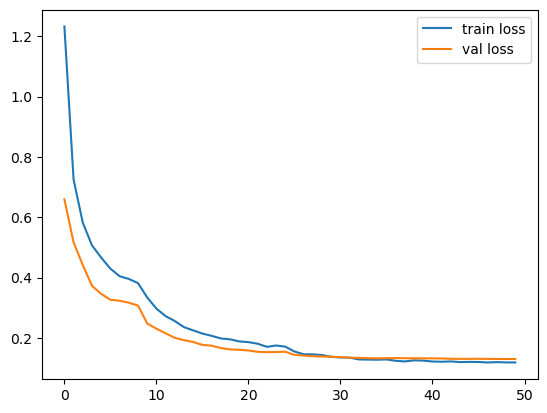

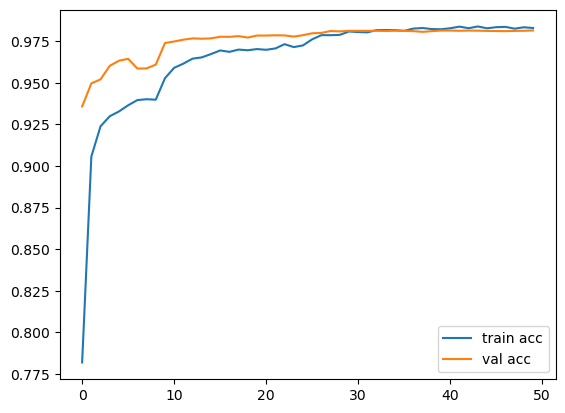

In [240]:
acc_loss_plots(history_FNN.history)

In [241]:
# evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy}")

438/438 - 1s - loss: 0.1354 - accuracy: 0.9804 - 689ms/epoch - 2ms/step
Test Accuracy: 0.9803571701049805


In [242]:
# make predictions using test set
predictions = model.predict(X_test)

438/438 [==============================] - 1s 2ms/step


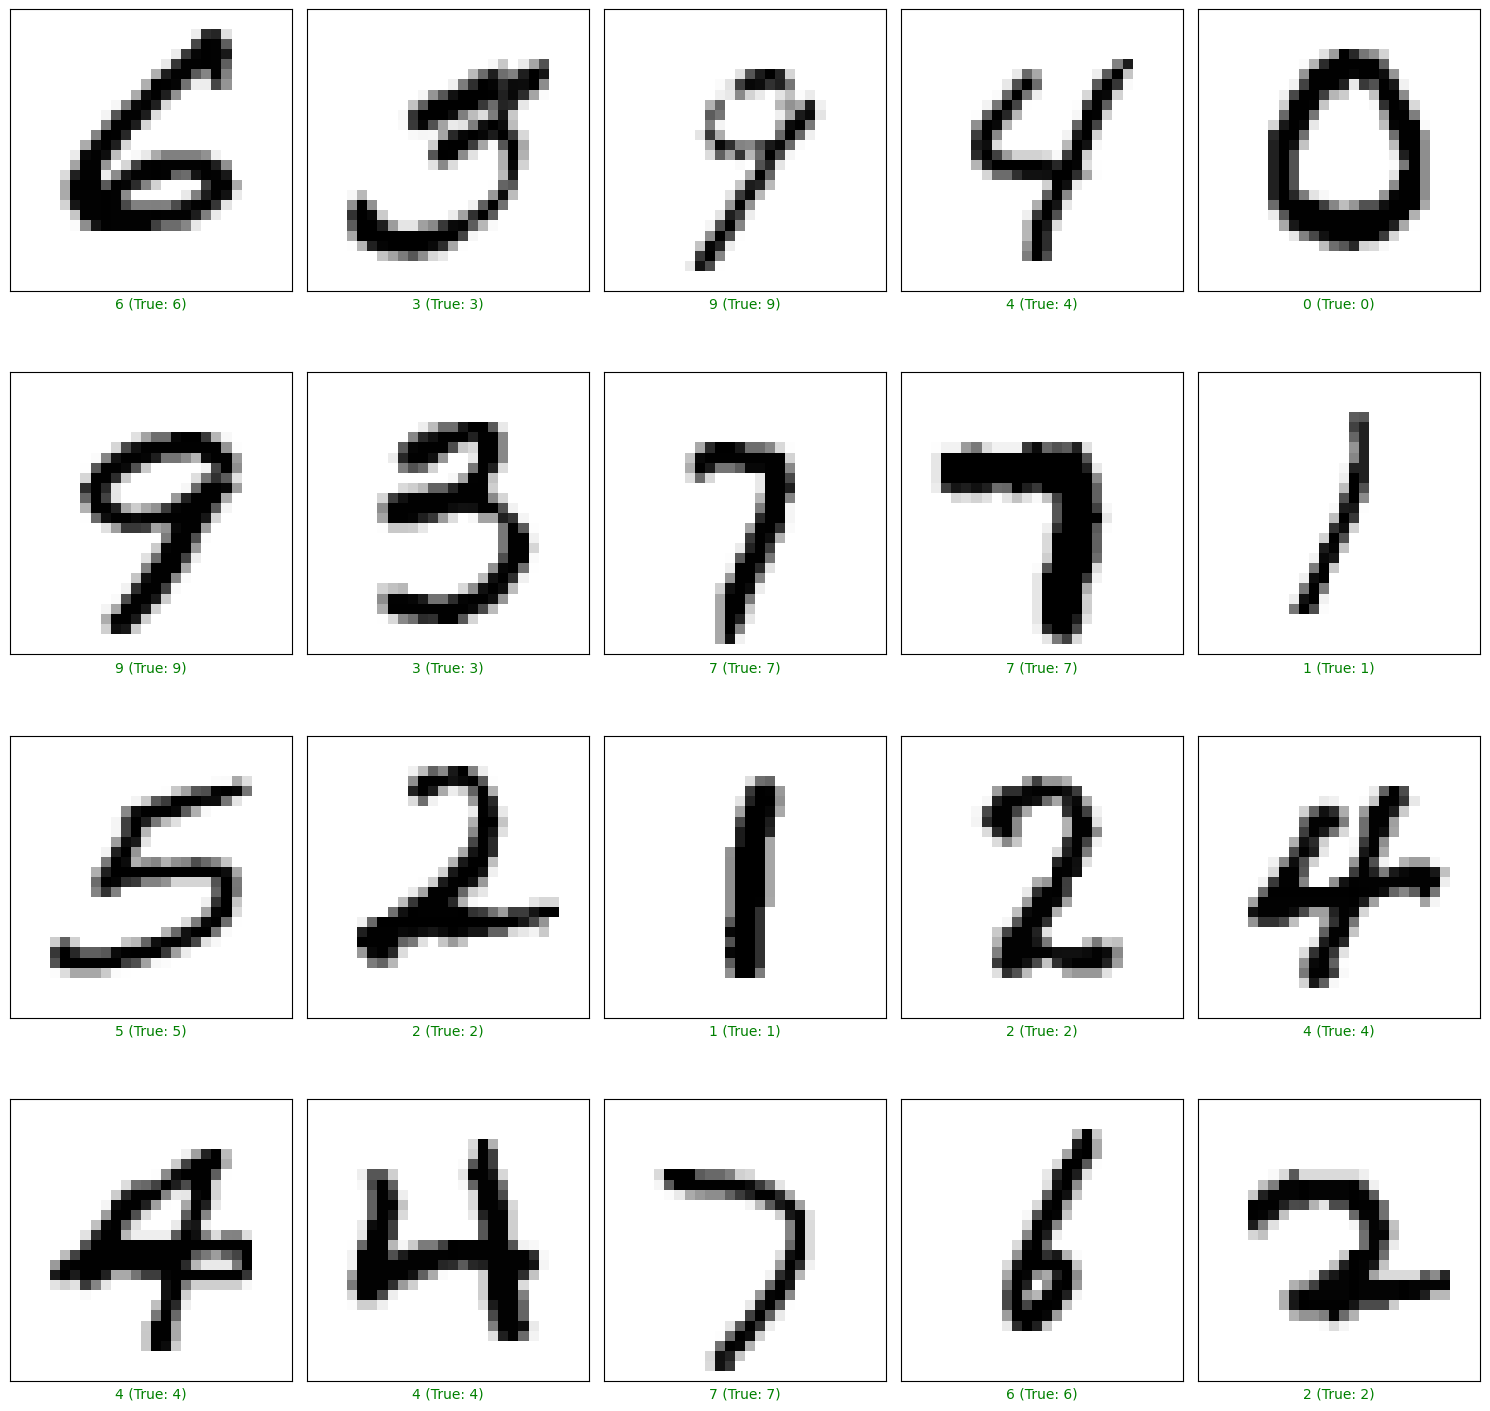

In [243]:
# visualize some predictions
classes_names = [str(i) for i in range(10)]
visualize_predictions(predictions, X_test, y_test, classes_names, 20,4,5)

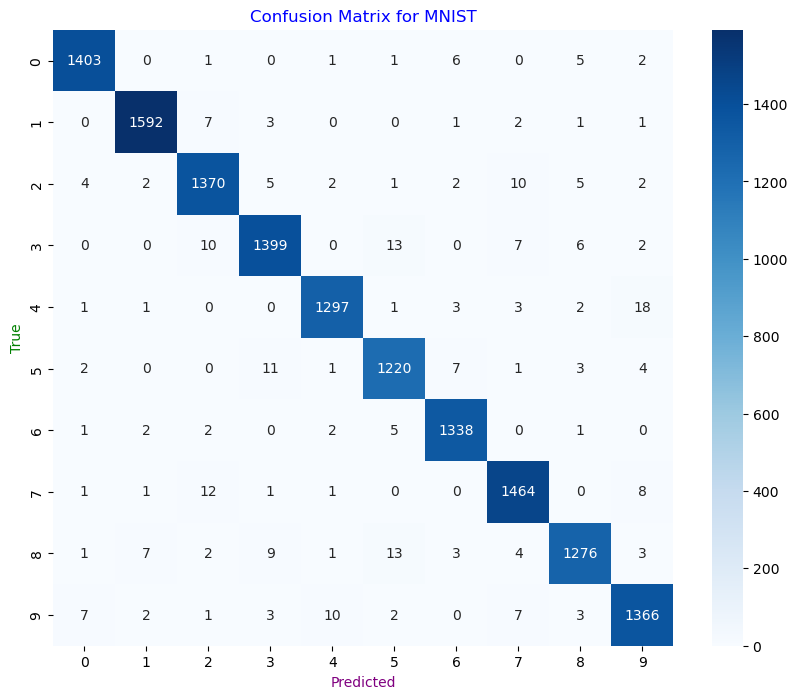

In [244]:
plot_confusion_matrix(predictions, y_test, classes_names, title="Confusion Matrix for MNIST", color="Blues")

# Comparison between softmax regression and feedforward neural network using keras

## 1. Final accuracy
- **Softmax regression**:
  - **Test accuracy**: 91.97%
  - Performance is strong for a simple linear model but limited by its inability to model non-linear relationships in the data.
- **FNN**:
  - **Test accuracy**: 97.96%
  - Significantly better due to its ability to learn complex patterns through multiple layers and non-linear activation functions.

## 2. Training time
- **Softmax regression**:
  - **Total training time**: 66 seconds
  - Faster training due to fewer parameters and simpler computations.
- **FNN**:
  - **Total training time**: 178 seconds
  - Slower because of the larger number of parameters and additional computations for backpropagation in deeper layers.

## 3. Loss trends
- **Softmax regression**:
  - Gradual decrease in training and validation loss over epochs.
  - Converges to a reasonable level but shows limited capacity to reduce loss further, indicating the model's simplicity.
- **FNN**:
  - Faster reduction in both training and validation loss.
  - Shows better convergence, aided by techniques like batch normalization, dropout, and L2 regularization.

## 4. Confusion matrices
- **Softmax regression**:
  - Likely to misclassify digits with overlapping features (e.g., 3 vs. 8, 4 vs. 9).
- **FNN**:
  - Fewer misclassifications due to its ability to learn hierarchical features, such as curves and edges.

## 5. Model architectures
- **Softmax regression**:
  - Single-layer linear model:
    - **Input**: Flattened 28x28 images.
    - **Output**: 10 classes.
  - Optimized with SGD and a learning rate of 0.01.
- **FNN**:
  - Deep architecture with four hidden layers:
    - Layers of 256, 128, 64, and 32 neurons.
    - **Activation**: ReLU.
    - **Regularization**: L2, dropout, and batch normalization.
  - Optimized with Adam and dynamic learning rate adjustment.

## 6. Hyperparameters
- **Softmax Regression**:
  - Fixed learning rate of 0.01.
  - No regularization or dynamic learning rate adjustment.
- **FNN**:
  - Learning rate starts at 0.001 and is dynamically reduced when validation accuracy plateaus.
  - Early stopping prevents overfitting.

---

# Conclusions

### Performance
- The FNN significantly outperforms softmax regression in terms of accuracy, making it more suitable for complex datasets like MNIST.

### Training Time
- Softmax regression trains faster, making it suitable for quick simple tasks.


| **Aspect**            | **Softmax Regression**                     | **Feedforward Neural Network (FNN)**        |
|------------------------|--------------------------------------------|---------------------------------------------|
| **Test accuracy**      | 91.97%                                     | 97.96%                                      |
| **Training time**      | 66 seconds                                 | 178 seconds                                 |
| **Loss trends**        | Gradual decrease; limited convergence      | Faster and deeper reduction; better convergence |
| **Confusion matrix**   | More misclassifications (e.g., 3 vs. 8)    | Fewer misclassifications; better feature extraction |
| **Model architecture** | Single-layer linear model                  | Multi-layer with 256, 128, 64, 32 neurons; ReLU activations |
| **Regularization**     | None                                       | L2 regularization, dropout, batch normalization |
| **Optimizer**          | SGD with fixed learning rate (0.01)        | Adam with dynamic learning rate adjustment  |
| **Scalability**        | Limited to linearly separable problems     | Handles non-linear and complex relationships |
